# COMP578 Data Mining Spring 2017
## Assignment 11

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import sklearn.decomposition
import sklearn.cluster
import scipy.cluster

from mpl_toolkits.mplot3d import Axes3D

import pydotplus
import IPython.display

import sklearn.externals.six  
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy

%matplotlib inline

url_data = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

## Columns: BI-RADS Assessment, Age, Shape, Margin, Density, Severity
names = ['BI-RADS', 'Age', 'Shape','Margin','Density','Severity']
data = pd.read_csv(url_data, header=None, names=names, na_values='?').dropna()
data = data.interpolate(method='linear', axis=0, inplace=False)
data = data[data['BI-RADS'] != 55.0]
data = data[data['BI-RADS'] != 6.0]

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Task 1
##### 10 points

Cluster the data in [Mammographic Mass Data Set](http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/) using k-means for `shape`, `margin`, and `density`.

Draw 3D clusters for $k\in\{2,3,4,5\}$.

Are the clusters created with $k=2$ aligned with the diagnosed `severity`?

Are the clusters created with $k=5$ aligned to the `BI_RADS` assessment?

In [3]:
def k_means_plot (data,num_clusters):
    X = data[['Shape','Margin','Density']]
    
    km1 = sklearn.cluster.KMeans(n_clusters=num_clusters, n_init=20)
    km1.fit(X)

    fig = plt.figure(figsize=(25,25))
    
    ax1 = Axes3D(fig)

    ax1.scatter(X['Shape'], X['Margin'], X['Density'], s=150, c=km1.labels_, cmap=plt.cm.prism) 
    ax1.set_title('K-Means Clustering Results with K='+str(num_clusters))
    ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

    plt.show()

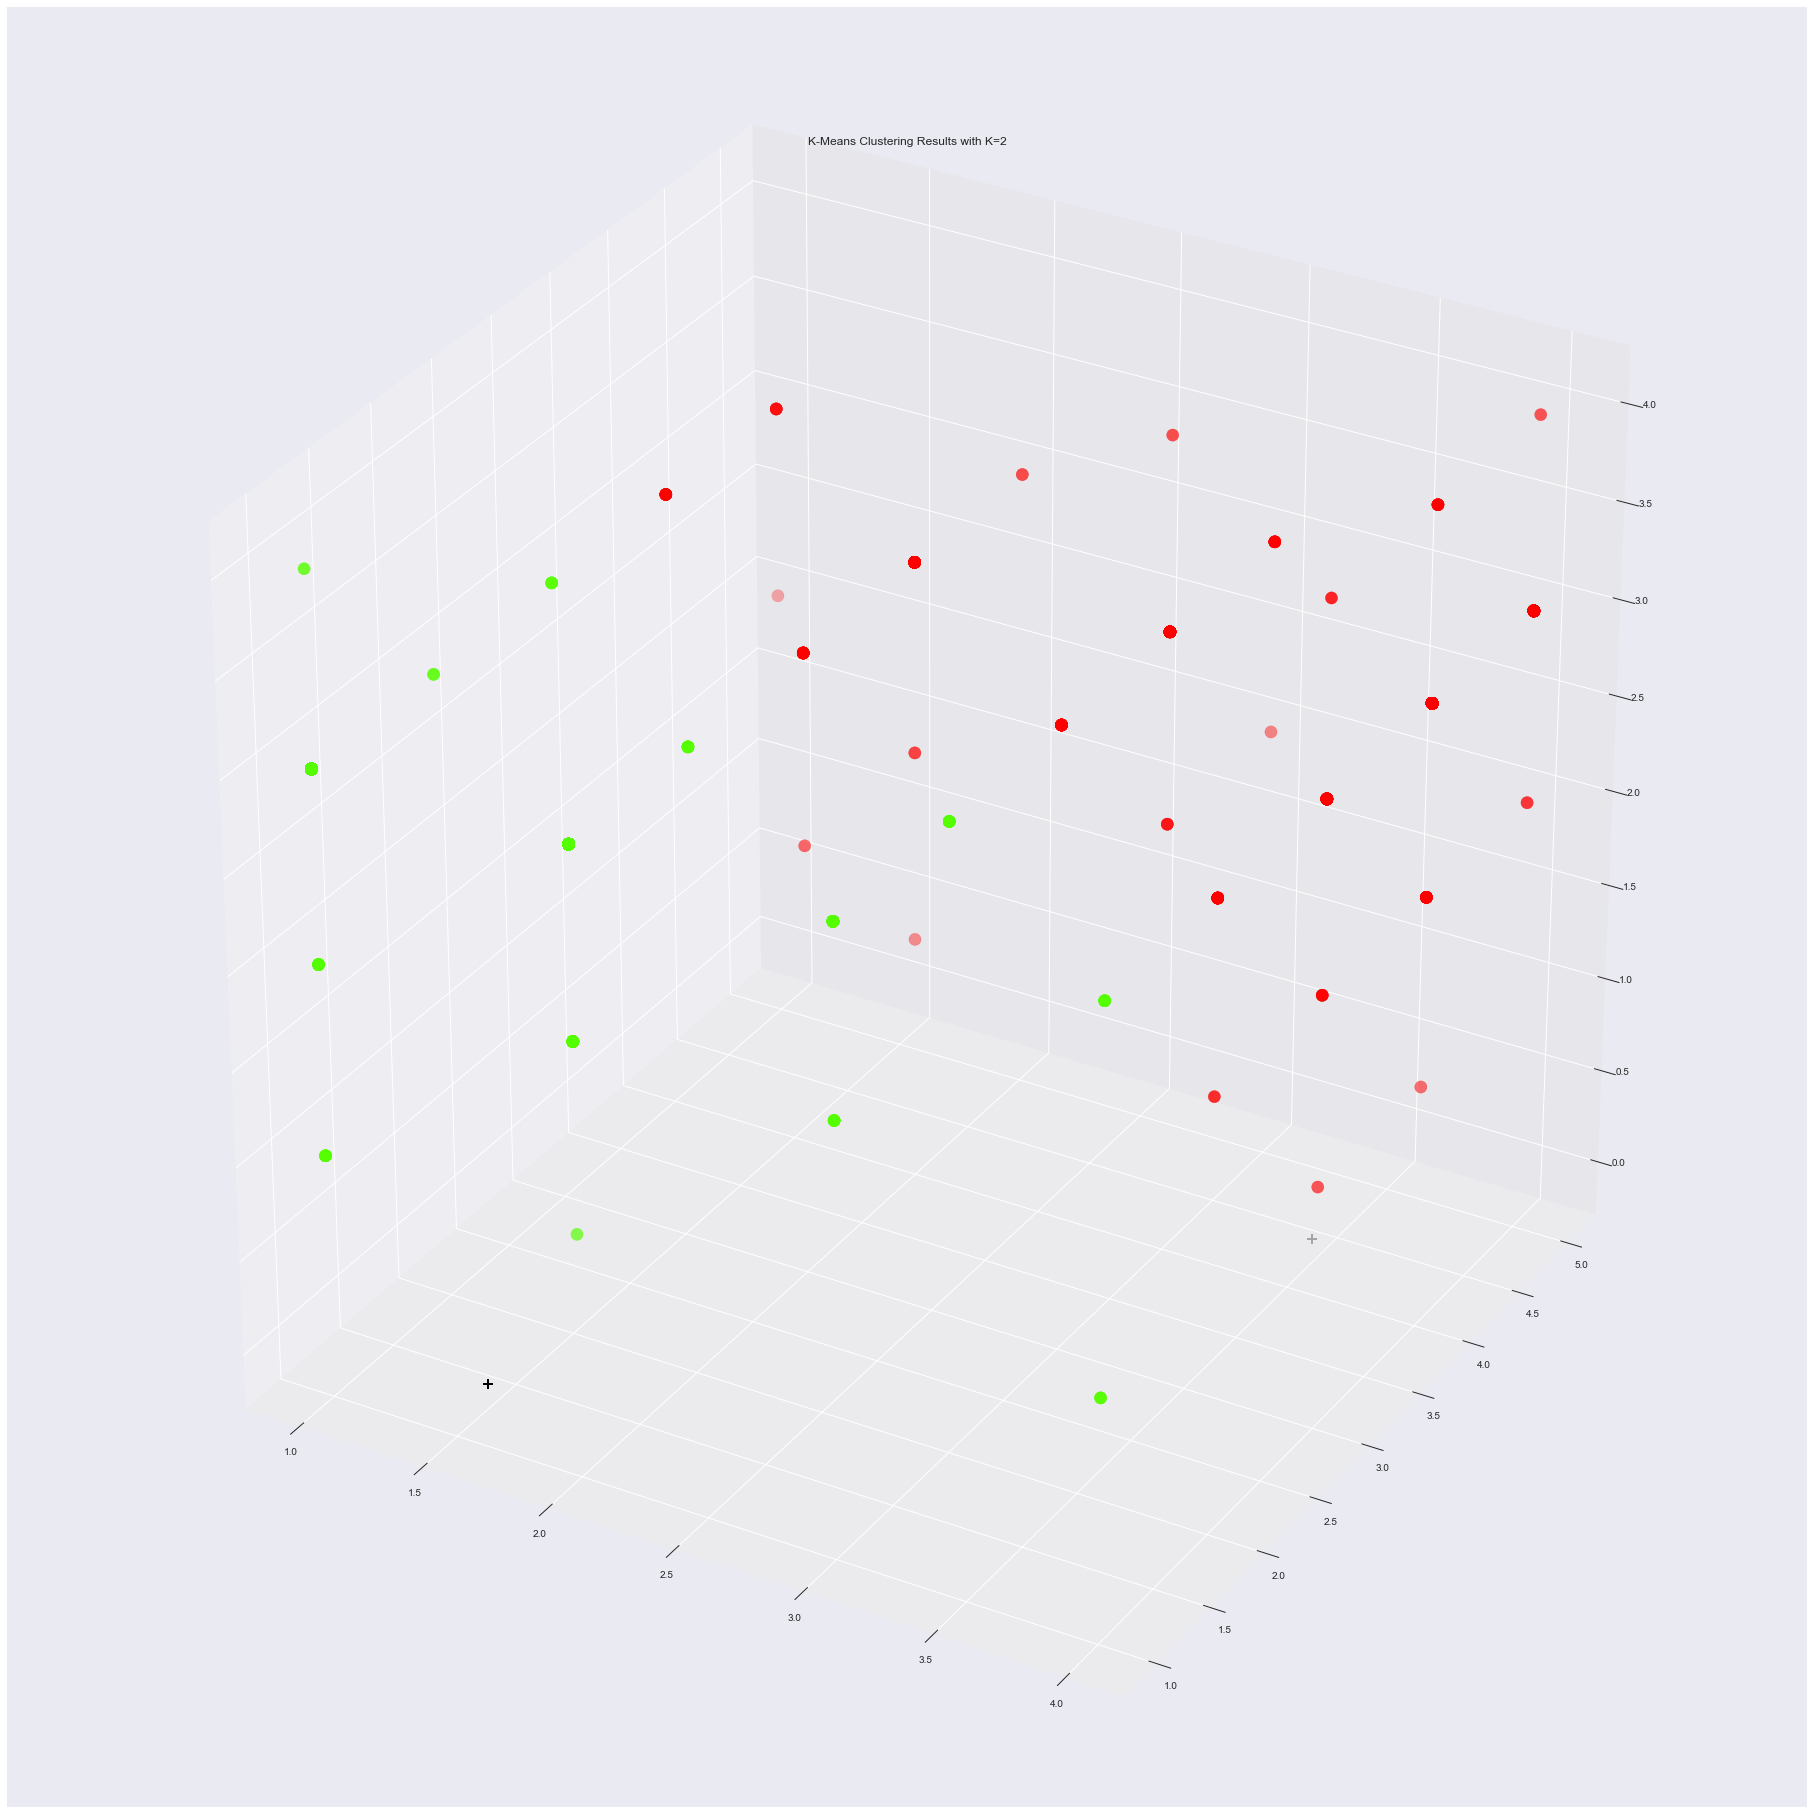

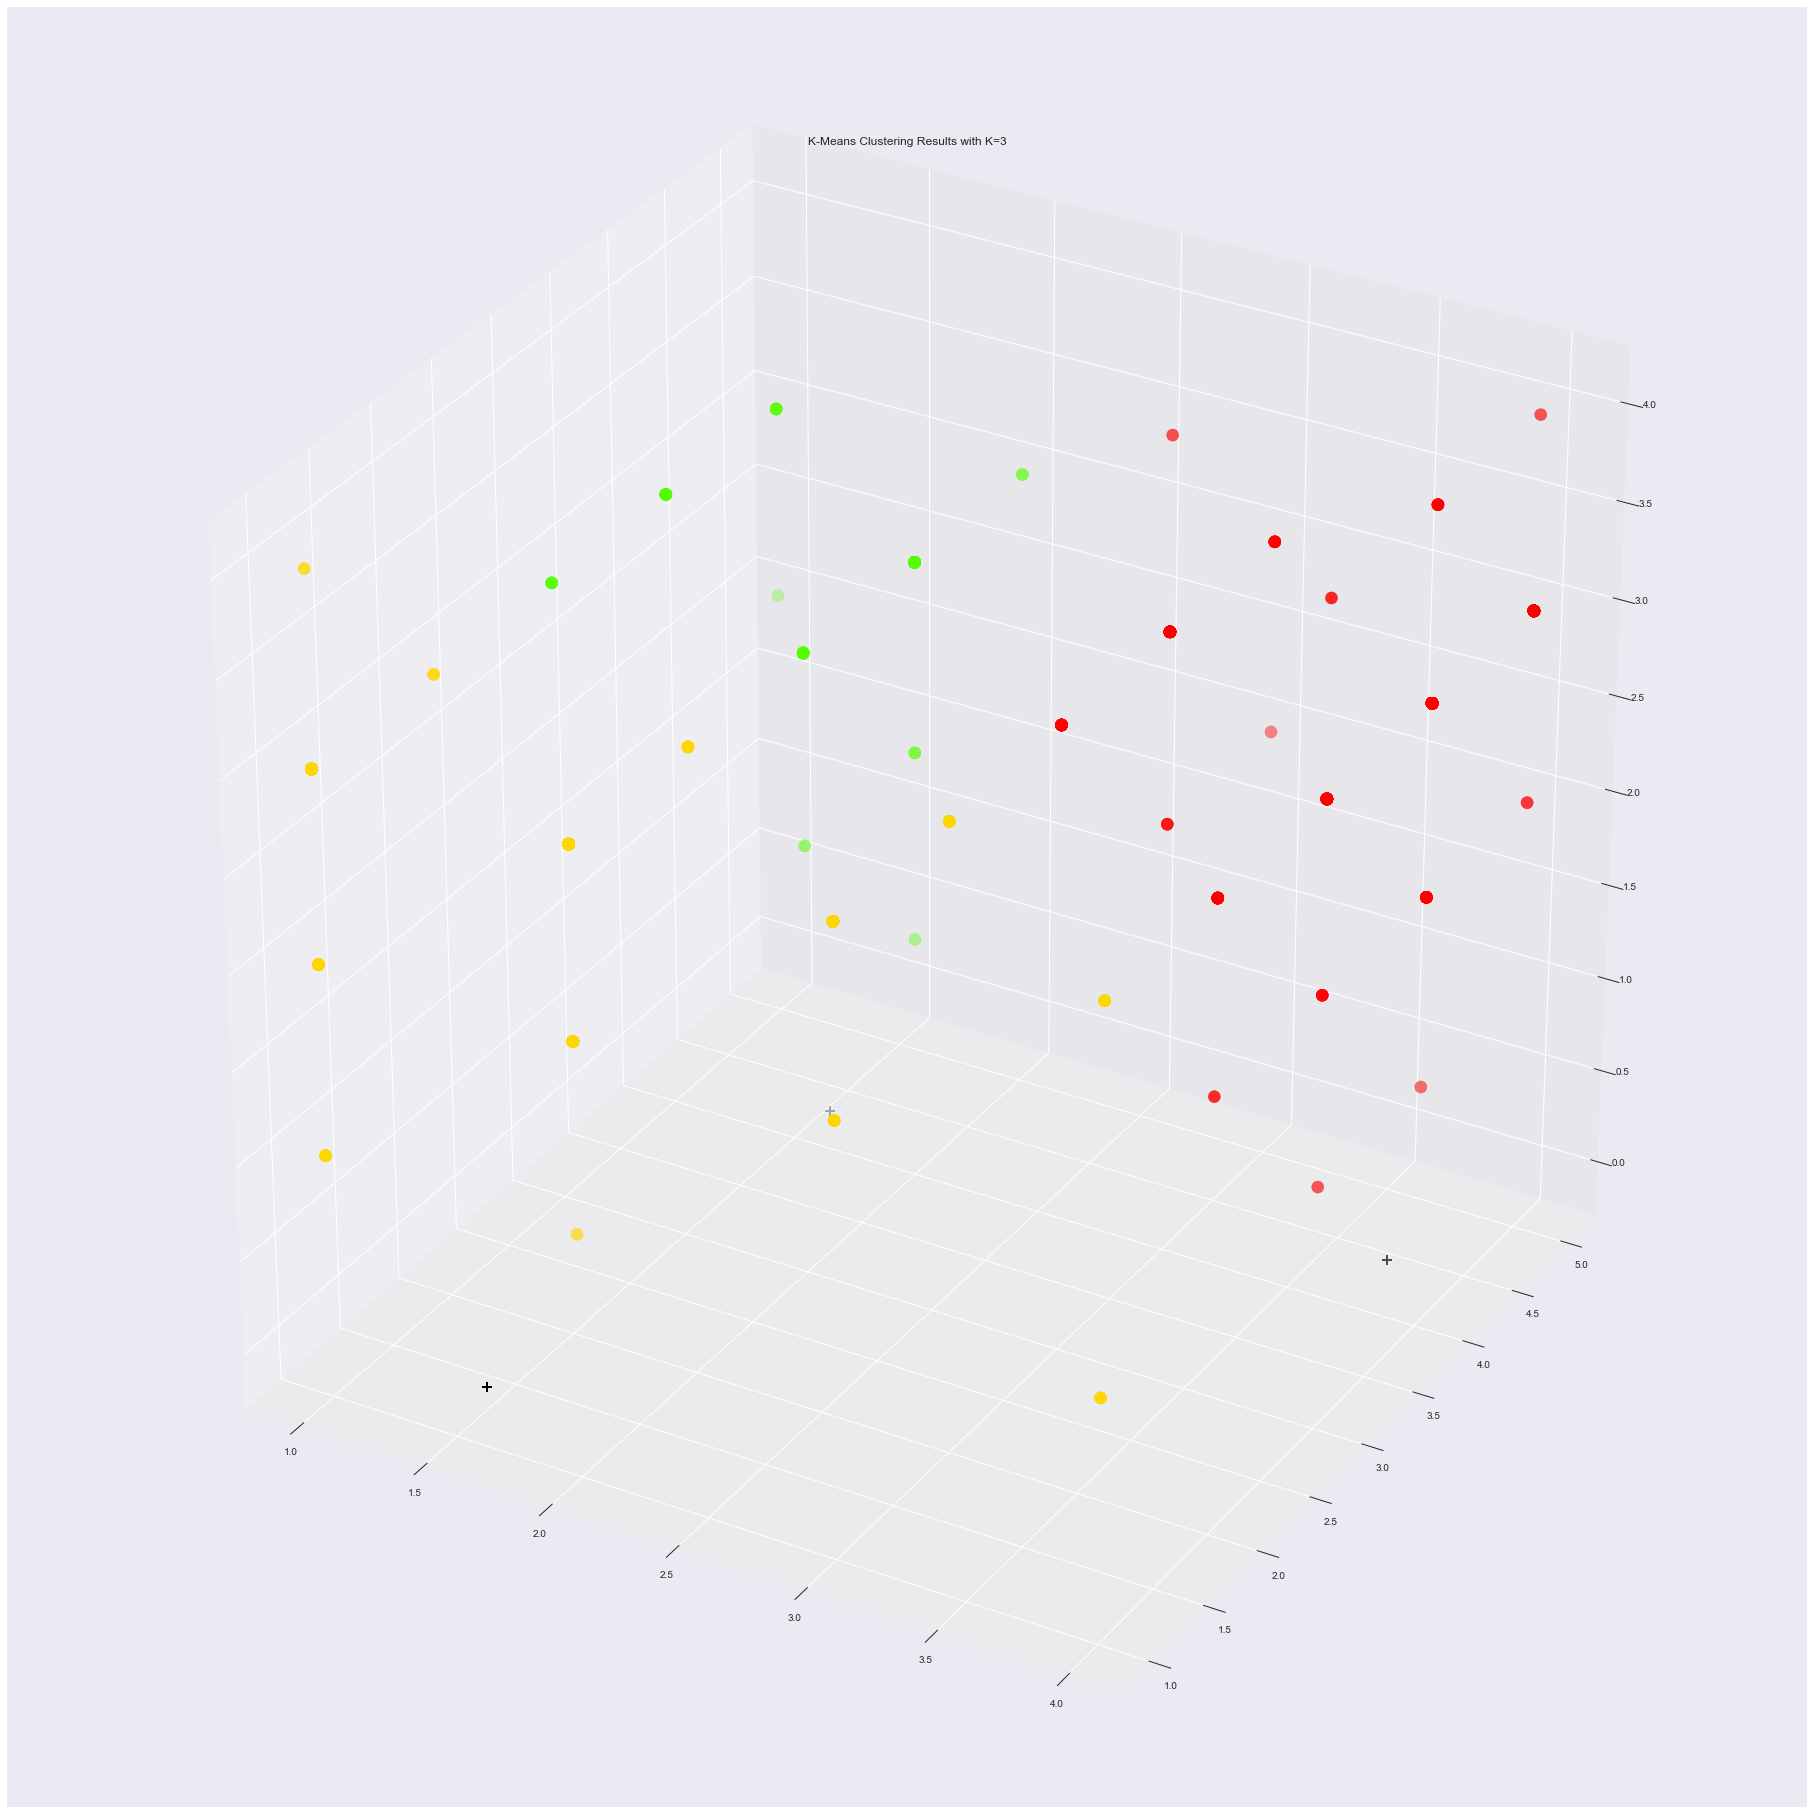

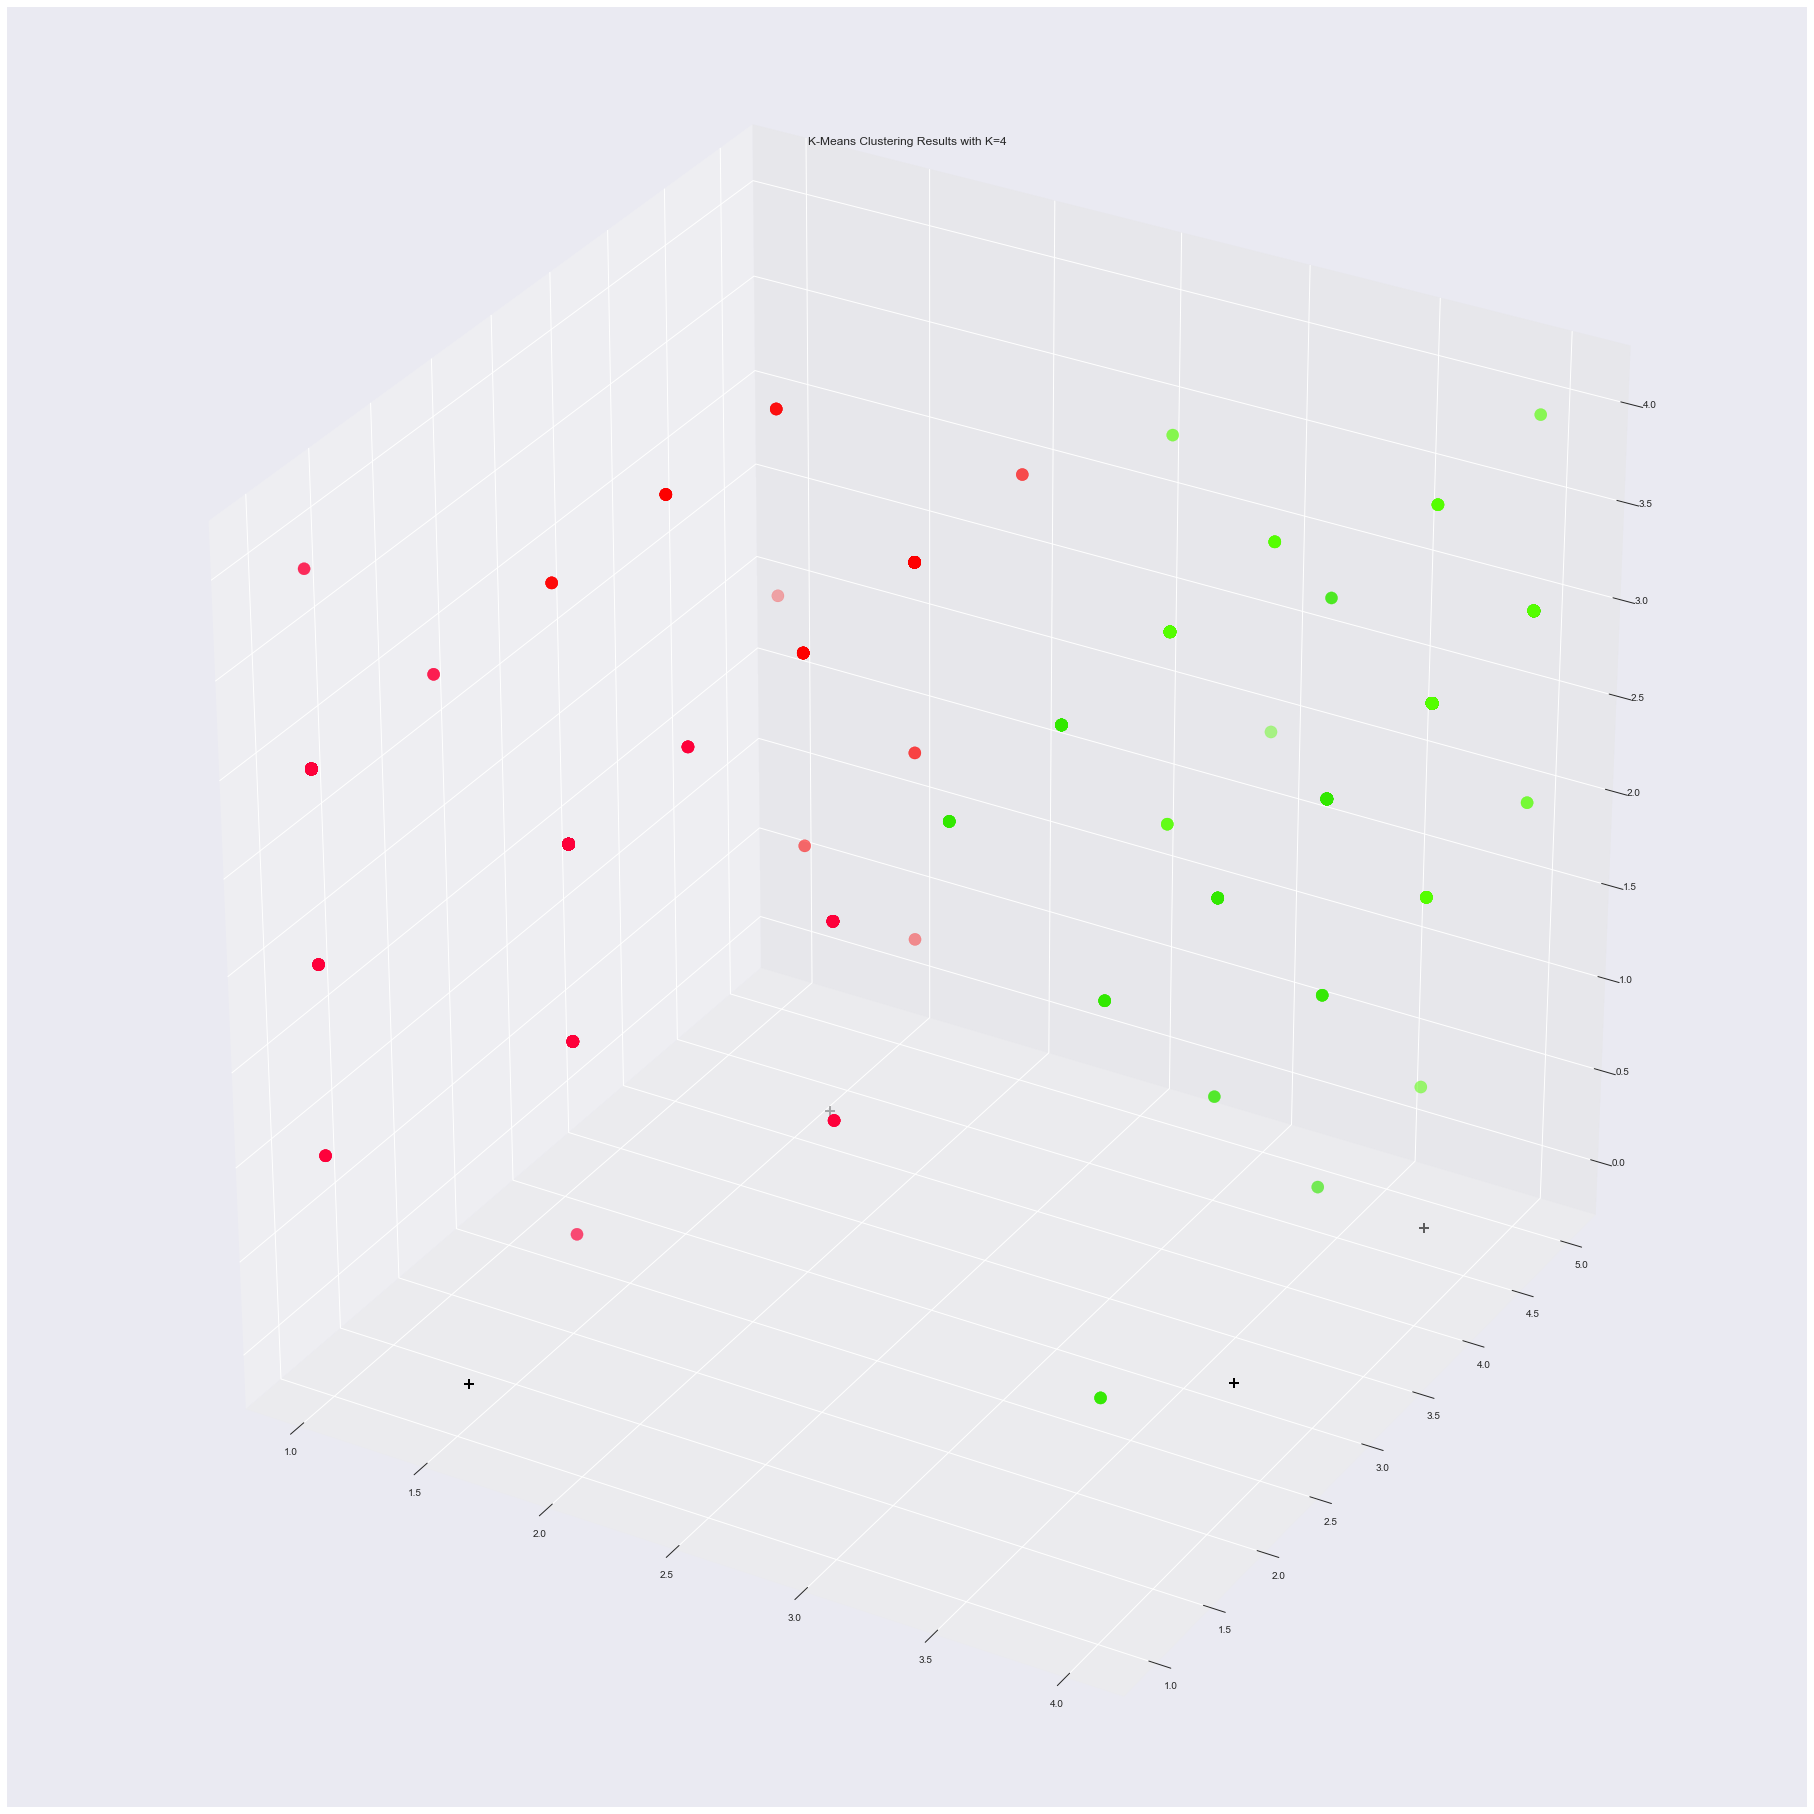

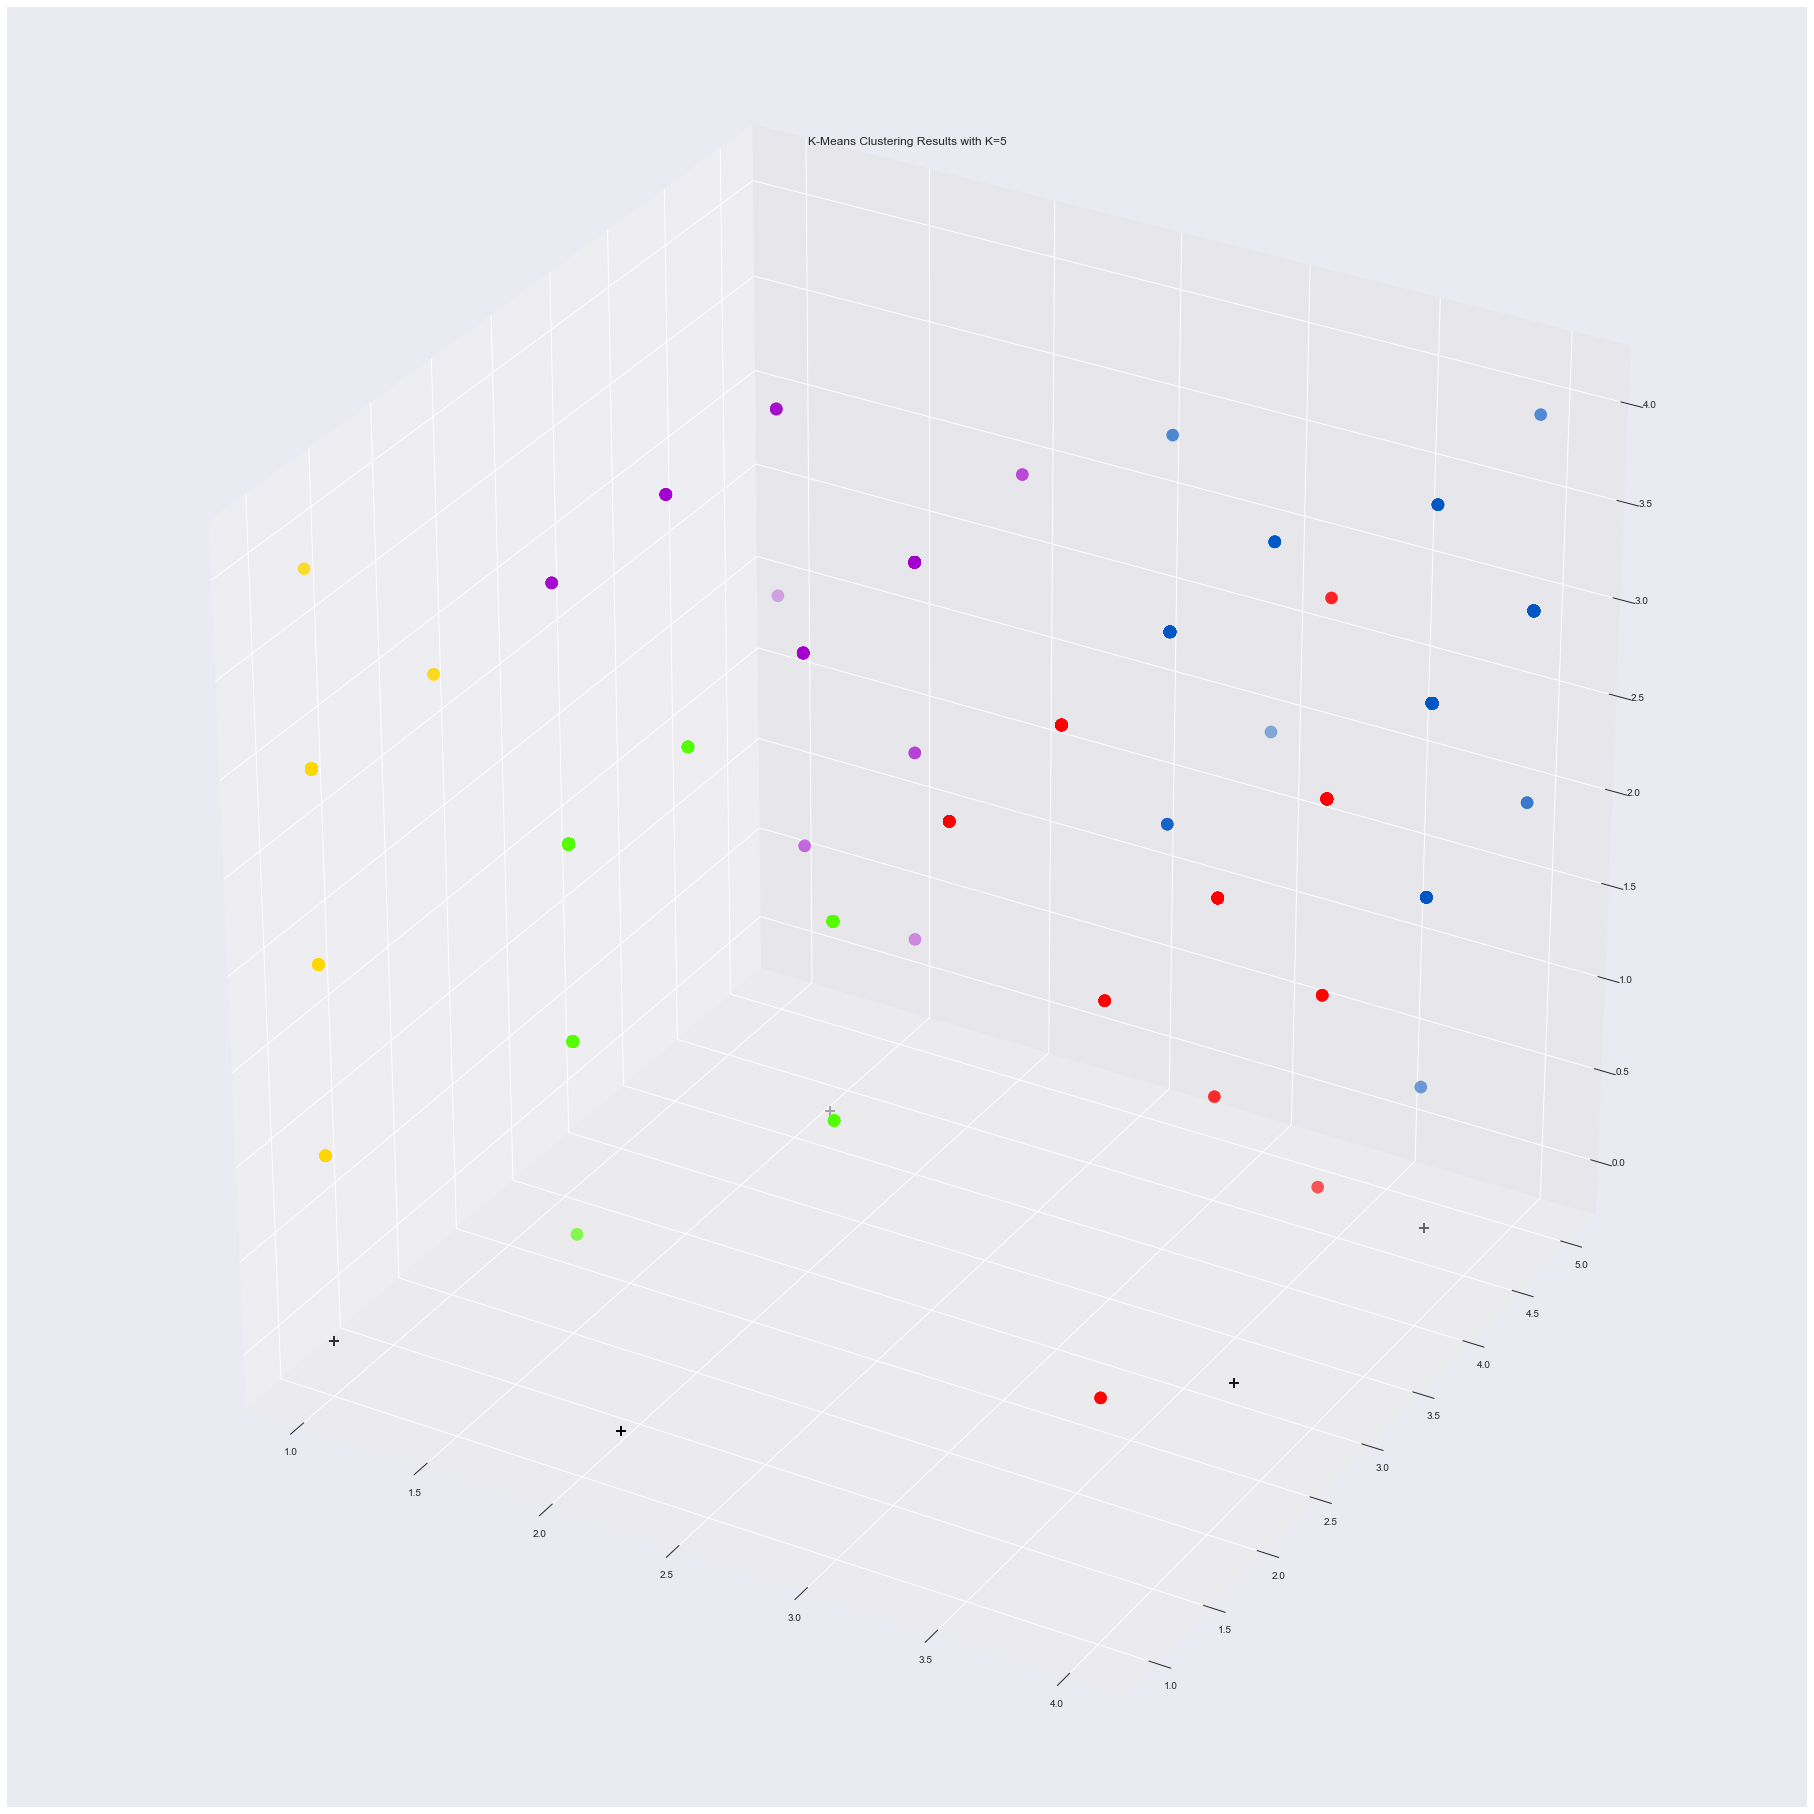

In [4]:
for numclust in (2,3,4,5):
    k_means_plot(data,numclust)

### Task 2
##### 10 points

Draw dendrograms for the data in [Mammographic Mass Data Set](http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/) for `shape`, `margin`, and `density`. Use the `dendrogram()` function from hierarchical clustering of Scipy with all 7 linkages.

Is any of the dendrograms aligned with `severity`? Make a cut in all of them for $p=2$ and check the distribution.

Is any of the dendrograms aligned with `BI-RADS`? Make a cut in all of them for $p=5$ (or something as close to that as possible) and check the distribution.

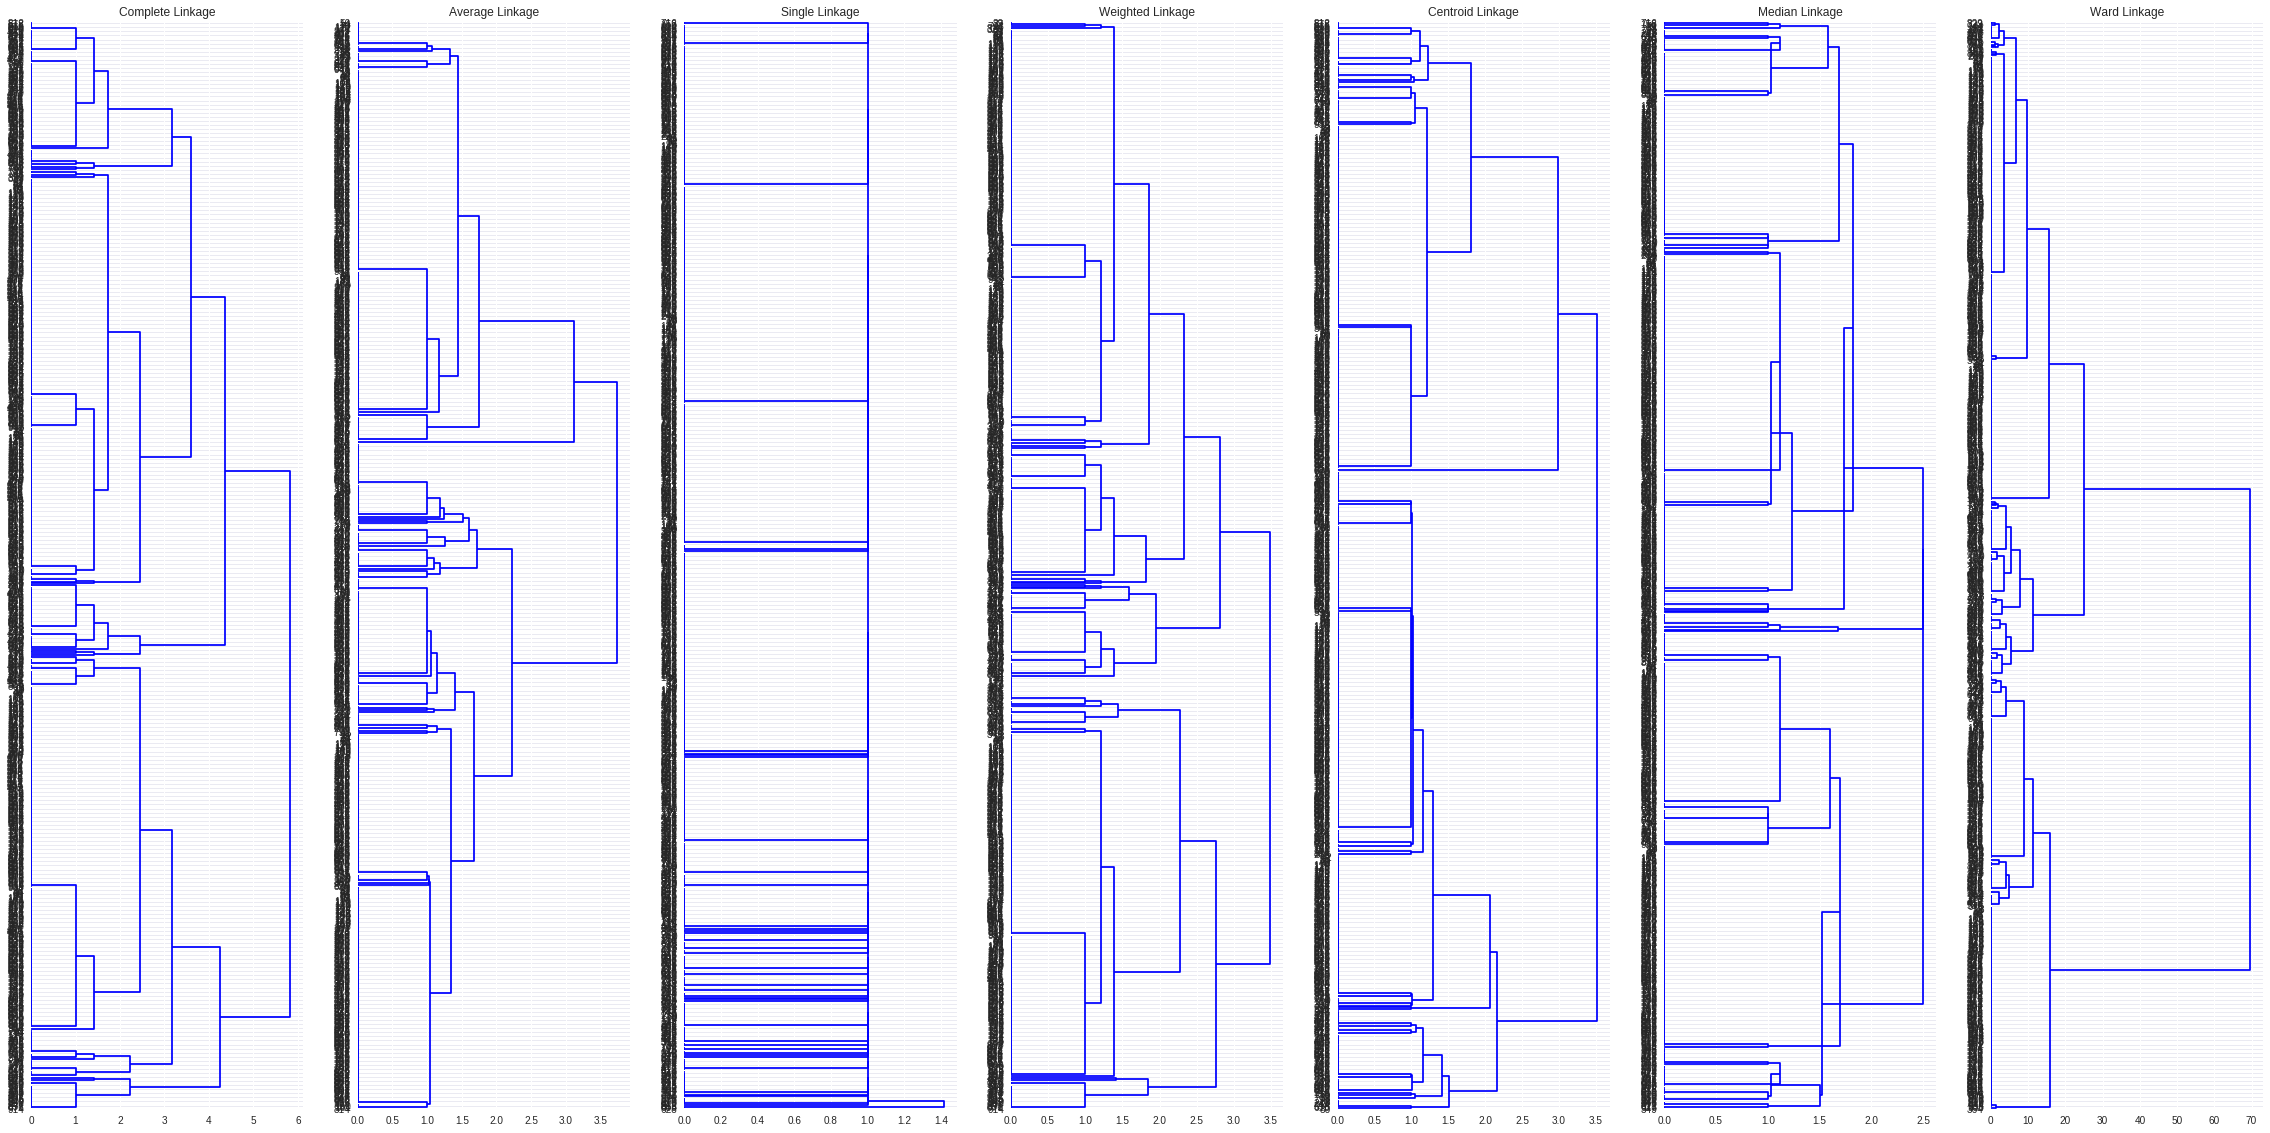

In [4]:
X = data[['Shape','Margin','Density']]
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7, figsize=(40,20))

for linkage, cluster, ax in zip([scipy.cluster.hierarchy.complete(X), 
                                 scipy.cluster.hierarchy.average(X), 
                                 scipy.cluster.hierarchy.single(X),
                                 scipy.cluster.hierarchy.weighted(X), 
                                 scipy.cluster.hierarchy.centroid(X), 
                                 scipy.cluster.hierarchy.median(X), 
                                 scipy.cluster.hierarchy.ward(X)],
                                ['c1','c2','c3','c4','c5','c6','c7'],
                                [ax1,ax2,ax3,ax4,ax5,ax6,ax7]):

    cluster = scipy.cluster.hierarchy.dendrogram(linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')
ax4.set_title('Weighted Linkage')
ax5.set_title('Centroid Linkage')
ax6.set_title('Median Linkage')
ax7.set_title('Ward Linkage')

plt.show()

0    425
1    395
Name: Severity, dtype: int64


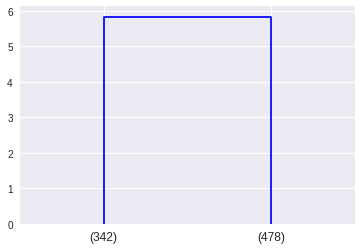

In [5]:
cut2 = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.complete(X), truncate_mode='lastp', p=2, show_leaf_counts=True)
print (data['Severity'].value_counts())

<i>Based on the differences between the actual Severity counts (425 and 395), and the counts of the dendogram branches (344,485), I think there is a potential correlation between them. The variance may be desirable in order to avoid overfitting the model to the data.</i>

4.0    468
5.0    316
3.0     24
2.0      7
0.0      5
Name: BI-RADS, dtype: int64


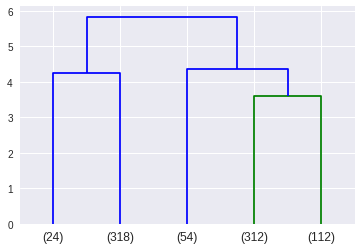

In [6]:
cut4b = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.complete(X), truncate_mode='lastp', p=5, show_leaf_counts=True)
print (data['BI-RADS'].value_counts())

Actual Counts: 468 - 316 - 24 - 7 - 5

Dendo. Counts: 318 - 312 - 112- 54 - 24

<i>The dendogram counts somewhat (but not definitevely) mirrors the acutal BI-RADS counts. Again, this may be ideal in order to prevent overfitting.</i>

### Task 3
##### 10 points

Using the LIDAR data set generate 1000 distorted points using bagging with repetitions. That is, select the data for a particular cue with a uniform distribution, and then apply the Gaussian distortion and save the new data point into the data set. Use $\mu=0.0$ and $\sigma=0.1$ in this task.

Implement the [LVQ algrithm](http://machinelearningmastery.com/learning-vector-quantization-for-machine-learning/) to created a codebook of the distorted LIDAR data starting with nine randomly selected codebook vectors.
> Of course, you should not be starting with the prototypes!

Draw nine graphs that show the original cue prototype and the learned code vector.

Use the correlation distance***

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [8]:
def get_labels(file):
    labels = []
    for i, line in enumerate(file):
        labels.append(line.strip().split(','))  
    return np.array(labels)

def get_curves(dir, shape):
    labels = get_labels(open(os.path.join(dir, "labels.txt")))
    curves = np.empty(shape)
    for i, curve_label in enumerate(labels[:, 0]):
        curves[i] = np.genfromtxt(os.path.join(dir, curve_label + ".dat"))

    np.place(curves, curves==0, [curves.max()]) # eliminate zeros (NaN in LIDAR jargon)
    curves = curves.astype(int)

    return curves, labels

curves, labels = get_curves('Data', (9,17))
print(curves)

lidar = pd.DataFrame(data=curves)
lidar = lidar.transpose()
lidar.columns = labels[:,0]
lidar

[[ 100  110  120  130  148  180  240  460  800  815  880  980 1130 1350
  1350  515  500]
 [ 100  110  120  130  148  180  885  820  800  815  880  850  700  600
   560  515  500]
 [ 100  110  120  130  148  180  885  820  800  815  880  980 1130 1350
  1350  515  500]
 [ 100  110  120  130  148  180  885  820 1350 1350 1190  980 1130 1350
  1350  515  500]
 [ 100  110  120  130  148  180  240  460 1350 1350 1190  980 1130 1350
  1350  515  500]
 [ 100  110  120  130  148  180  885  820 1350 1350 1190  850  700  600
   560  515  500]
 [ 100  110  120  130  148  180  465  515  800  815  880  850  700  600
   560  515  500]
 [ 100  110  120  130  148  180  240  460 1350 1350 1190  850  700  730
   670  515  500]
 [ 100  110  120  130  148  180  465  515 1350 1350 1190  850  700  730
   670  515  500]]


,lt,rt,ts,xs,tl,tr,dr,dl,d2
0,100,100,100,100,100,100,100,100,100
1,110,110,110,110,110,110,110,110,110
2,120,120,120,120,120,120,120,120,120
3,130,130,130,130,130,130,130,130,130
4,148,148,148,148,148,148,148,148,148
5,180,180,180,180,180,180,180,180,180
6,240,885,885,885,240,885,465,240,465
7,460,820,820,820,460,820,515,460,515
8,800,800,800,1350,1350,1350,800,1350,1350
9,815,815,815,1350,1350,1350,815,1350,1350


In [9]:
def get_distorted_curve(curve, sigma=0.1, mu=0):
  length = len(curve)
  return curve * (1 + np.random.normal(mu, sigma, length))

In [10]:
#create dataframe that holds 1000 distorted data points FOR A SINGLE CUE
lidar_trans = lidar.transpose()
lidar_gaus = pd.DataFrame(index = np.arange(1000),columns=lidar.index)

def codebook(lidar_gaus,lidar_trans,case):
    import random
    
    lidar_best = pd.DataFrame(index = lidar_trans.index, columns=np.arange(17))

    for y in range (0,9):
        if case == 0:
            train_vector = lidar_gaus.iloc[random.randint(1,1000)] # we want to measure against the a random vector
        if case == 1:
            train_vector = lidar_trans.iloc[y] # we want to measure against the original
        for x in range (0,1000):
            lidar_gaus.iloc[x] = get_distorted_curve(curves[y]) #distorted curves for left turn (lt)

        distance = scipy.spatial.distance.correlation(train_vector,lidar_gaus.iloc[1])
        bestx = 0
        for x in range (1,1000):
            newdistance = scipy.spatial.distance.correlation(train_vector,lidar_gaus.iloc[x])
            if newdistance < distance:
                distance = newdistance
                bestx = x
        print(bestx, distance)

        lidar_best.iloc[y] = lidar_gaus.iloc[bestx]

    return(lidar_best)
lidar_random = codebook(lidar_gaus,lidar_trans,case=0)
lidar_original = codebook(lidar_gaus,lidar_trans,case=1)

288 -2.22044604925e-16
662 1.11022302463e-16
406 0.0
371 0.0
406 -2.22044604925e-16
977 0.0
605 0.0
407 0.0
308 0.0
503 0.00113334586383
99 0.00199374268498
946 0.00171739240284
80 0.00246268183868
126 0.00114452860336
297 0.00150125795332
782 0.0024704217613
348 0.00160503025515
117 0.00122421663655


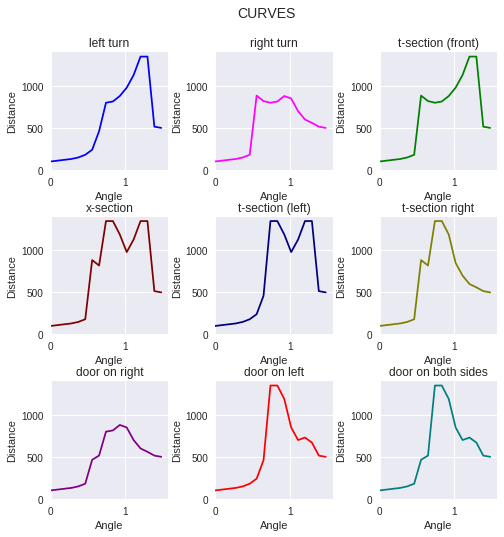

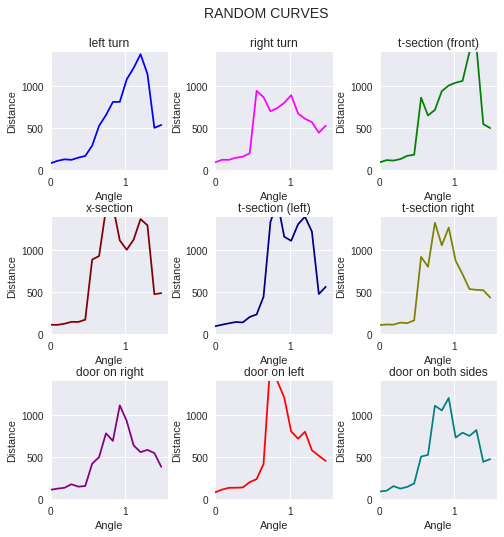

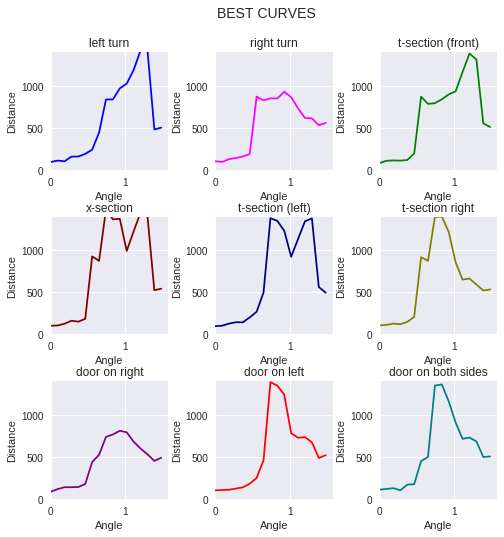

In [11]:
#original plots
fig = plt.figure(None, [8, 8])
plt.suptitle("CURVES", fontsize=14)

ax = plt.gca()
colors_ = ['Blue', 'Fuchsia', 'Green', 'Maroon', 'Navy', 'Olive', 'Purple', 'Red', 'Teal']

for i, label, curve, color in zip(range(len(labels)), labels[:, 1].T, curves, itertools.cycle(colors_)):
    plt.subplot(3, 3, i+1)
    ax = plt.gca()
    ax.set_title(label)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Angle")
    ax.set_ylim(0, 1400)
    ax.set_xlim(0, np.pi/2)
    plt.plot(np.arange(0, np.pi/2, np.pi/2 / 17), curve, c=color)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=0.4, hspace=0.4)
# fig.tight_layout()

plt.show()
print('=================================================================================================')
###====================================================================================================
#best randomized plots
random_curves = lidar_random.as_matrix()

fig = plt.figure(None, [8, 8])
plt.suptitle("RANDOM CURVES", fontsize=14)

ax = plt.gca()
colors_ = ['Blue', 'Fuchsia', 'Green', 'Maroon', 'Navy', 'Olive', 'Purple', 'Red', 'Teal']

for i, label, curve, color in zip(range(len(labels)), labels[:, 1].T, random_curves, itertools.cycle(colors_)):
    plt.subplot(3, 3, i+1)
    ax = plt.gca()
    ax.set_title(label)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Angle")
    ax.set_ylim(0, 1400)
    ax.set_xlim(0, np.pi/2)
    plt.plot(np.arange(0, np.pi/2, np.pi/2 / 17), curve, c=color)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=0.4, hspace=0.4)
# fig.tight_layout()

plt.show()
print('=================================================================================================')
###====================================================================================================
#best randomized plots
best_curves = lidar_original.as_matrix()

fig = plt.figure(None, [8, 8])
plt.suptitle("BEST CURVES", fontsize=14)

ax = plt.gca()
colors_ = ['Blue', 'Fuchsia', 'Green', 'Maroon', 'Navy', 'Olive', 'Purple', 'Red', 'Teal']

for i, label, curve, color in zip(range(len(labels)), labels[:, 1].T, best_curves, itertools.cycle(colors_)):
    plt.subplot(3, 3, i+1)
    ax = plt.gca()
    ax.set_title(label)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Angle")
    ax.set_ylim(0, 1400)
    ax.set_xlim(0, np.pi/2)
    plt.plot(np.arange(0, np.pi/2, np.pi/2 / 17), curve, c=color)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=0.4, hspace=0.4)
# fig.tight_layout()

plt.show()

The randomized vectors chosen based on correlation distance closely lined up with the prototypes. This was expected. Some things I notice are that the curves are choppier than the original, which is to be expected given the gausian randomization applied to the original data.

Out of curiosity I also chose vectors chosen against the prototype. Again these are noisy, but line up very well with the prototypes.